Train shape: 7602, Test shape: 1966
Accuracy: 0.7930
Precision: 0.8076
Recall: 0.7930
F1-score: 0.7116
Classification Report:
               precision    recall  f1-score   support

           0     0.7922    0.9981    0.8833      1543
           1     0.8636    0.0449    0.0854       423

    accuracy                         0.7930      1966
   macro avg     0.8279    0.5215    0.4843      1966
weighted avg     0.8076    0.7930    0.7116      1966



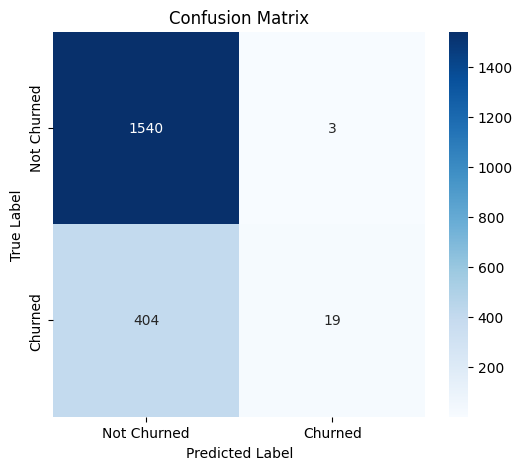

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Churn Prediction with PySpark ML") \
    .getOrCreate()

# Step 2: Read the dataset
data_path = 'C:/Users/PC/Desktop/Do_an_Big_data/PythonCodes/work/data/Churn_Modelling_FE.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Drop ineffective columns
df = df.drop('RowNumber', 'CustomerId', 'Surname')

# Step 3: Separate features and label
feature_cols = [col for col in df.columns if col != 'Exited']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Step 4: Feature Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Select only scaled features and label
df = df.select(col("scaled_features").alias("features"), col("Exited").alias("label"))

# Step 5: Split the dataset into train and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=0)
print(f"Train shape: {train_df.count()}, Test shape: {test_df.count()}")

# Step 6: Handle class imbalance with class weights (alternative to SMOTEN)
# Calculate class weights based on imbalance
label_counts = train_df.groupBy("label").count().collect()
total = label_counts[0]['count'] + label_counts[1]['count']
weight_0 = total / (2.0 * label_counts[0]['count'])  # Weight for majority class (0)
weight_1 = total / (2.0 * label_counts[1]['count'])  # Weight for minority class (1)

# Add a weight column to the training data
train_df = train_df.withColumn("weight", 
                               when(col("label") == 0, weight_0).otherwise(weight_1))

# Step 7: Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="weight", maxIter=100)
lr_model = lr.fit(train_df)

# Step 8: Make predictions
predictions = lr_model.transform(test_df)

# Step 9: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Classification report (approximated)
prediction_and_labels = predictions.select("prediction", "label").toPandas()
print("Classification Report:\n", 
      classification_report(prediction_and_labels["label"], prediction_and_labels["prediction"], digits=4))

# Step 10: Confusion Matrix Visualization
conf_matrix = confusion_matrix(prediction_and_labels["label"], prediction_and_labels["prediction"])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 11: Save the model
lr_model.write().overwrite().save("C:/Users/PC/Desktop/Do_an_Big_data/PythonCodes/work/models/logic_regression/lr_model_spark")

# Stop Spark session
spark.stop()